In [1]:
import glob
import math
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

traffic_path = '../../SmartCity-master/traffic\\'
daily_folder = "daily"
separator = ';'
date_column = 'Dátum'


def read_all_traffic_daily():
    path = "D:/Szakdolgozat/SmartCity-master/traffic/AP1/10min/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=separator, index_col=None, header=0))

    return convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))

weather_separator = ','
weather_date_column = 'datum'


def read_all_weather():
    path = "D:/Szakdolgozat/SmartCity-master/weather/Janostol/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=weather_separator, index_col=None, header=0))

    return weather_convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))


def convert_to_date(data):
    data[date_column] = pd.to_datetime(data[date_column]).apply(lambda x: x.replace(second=0, microsecond=0))
    data[date_column] = data[date_column].apply(lambda x: x.replace(minute= (math.floor(x.minute / 10) * 10)))
    return data

def weather_convert_to_date(data):
    data[weather_date_column] = pd.to_datetime(data[weather_date_column]).apply(lambda x: x.replace(second=0, microsecond=0))
    data[weather_date_column] = data[weather_date_column].apply(lambda x: x.replace(minute= (math.floor(x.minute / 10) * 10)))
    return data


In [2]:
wdf = read_all_weather()
#wdf[weather_date_column] = wdf[weather_date_column].dt.datetime
wdf = wdf[(wdf[weather_date_column] >= pd.to_datetime("2020-02-22 22:00:00")) & (wdf[weather_date_column] <= pd.to_datetime("2020-09-09 09:10:00"))]
wdf.rename(columns={'datum': 'Dátum'}, inplace=True)
wdf = wdf[wdf['telepules'] == 'k']
wdf

,Dátum,telepules,homerseklet,atlaghom.,max. hom,min. hom,felszinkozeli,felsz. min.,relativ nedv.,absz. legnyomas,szelsebesseg,szelirany,csapaded,globalsug.
15188,2020-02-22 22:00:00,k,2.8,2.8,3,2.7,-,-,69,1018,3.7,193,-,1
15190,2020-02-22 22:10:00,k,3.2,3,3.2,2.9,-,-,69,1017.8,4.5,192,-,1
15192,2020-02-22 22:20:00,k,3.5,3.3,3.5,3.2,-,-,68,1017.7,4.3,194,-,1
15194,2020-02-22 22:30:00,k,3.7,3.6,3.7,3.5,-,-,66,1017.6,4.6,198,-,1
15196,2020-02-22 22:40:00,k,3.7,3.8,3.8,3.7,-,-,64,1017.5,4.8,193,-,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72301,2020-09-09 08:30:00,k,23.8,23.9,24,23.8,-,-,35,1016.9,1.1,234,-,629.1
72303,2020-09-09 08:40:00,k,24,23.9,24,23.8,-,-,35,1016.8,1.2,356,-,647.8
72305,2020-09-09 08:50:00,k,24.5,24.3,24.5,24,-,-,35,1016.7,1.3,174,-,664.9
72307,2020-09-09 09:00:00,k,24.8,24.7,24.9,24.5,-,-,35,1016.6,1.1,219,-,681.5


In [3]:
df = read_all_traffic_daily()
df = pd.merge(df, wdf[['Dátum', 'atlaghom.']], on=['Dátum'], how='inner')

In [4]:
df.rename(columns={'Irány 0 - Autók számossága': 'Belváros felé - Autók számossága',
                   'Irány 1 - Autók számossága': 'Újszeged felé - Autók számossága',}, inplace=True)

df = df.sort_values('Dátum', ascending=True)
#df[df.duplicated(subset=['Dátum'], keep=False)]
df['Hour'] = df[date_column].dt.hour
df['Minute'] = df[date_column].dt.minute
df[date_column] = df[date_column].dt.date
df = df.drop(df[df['atlaghom.'] == "-"].index)
df['prev'] = df['Újszeged felé - Autók számossága'].shift()
df = df.iloc[1:]

df.head(50)

,Dátum,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,atlaghom.,Hour,Minute,prev
1,2020-02-22,10,4,0,1,0,0,0,0,0,0,2.2,23,30,7.0
2,2020-02-22,17,27,5,0,2,1,1,0,1,0,2.4,23,50,4.0
56,2020-02-23,17,30,1,3,8,3,0,0,0,0,2,0,0,27.0
8,2020-02-23,15,35,1,3,0,5,0,0,0,0,1.9,0,10,30.0
13,2020-02-23,17,18,0,0,0,0,0,1,0,0,2.1,0,20,35.0
30,2020-02-23,14,14,2,1,1,1,0,0,0,0,2,0,30,18.0
24,2020-02-23,9,22,0,2,0,0,0,0,0,0,1.8,0,40,14.0
65,2020-02-23,15,23,2,1,1,3,0,0,0,0,1.7,0,50,22.0
39,2020-02-23,2,0,0,0,0,0,0,0,0,0,2.1,1,0,23.0
111,2020-02-23,9,20,1,1,3,2,0,0,0,0,1.8,1,10,0.0


In [5]:
#df.sort_values('Irány 0 - Gyalogosok számossága', ascending=False).head(50)

In [6]:
df['DayOfWeek'] = pd.DatetimeIndex(df[date_column]).dayofweek

df['Monday'] = df['DayOfWeek'] == 0
df['Tuesday'] = df['DayOfWeek'] == 1
df['Wednesday'] = df['DayOfWeek'] == 2
df['Thursday'] = df['DayOfWeek'] == 3
df['Friday'] = df['DayOfWeek'] == 4
df['Saturday'] = df['DayOfWeek'] == 5
df['Sunday'] = df['DayOfWeek'] == 6

df['Curfew'] = (df[date_column] >= pd.to_datetime("2020-03-28")) & (df[date_column] <= pd.to_datetime("2020-05-04"))
df['Holiday'] = (df[date_column] == pd.to_datetime("2020-03-15")) | (df[date_column] == pd.to_datetime("2020-04-10")) | (df[date_column] == pd.to_datetime("2020-04-12")) | (df[date_column] == pd.to_datetime("2020-04-13")) | (df[date_column] == pd.to_datetime("2020-05-01")) | (df[date_column] == pd.to_datetime("2020-05-31")) | (df[date_column] == pd.to_datetime("2020-06-01")) | (df[date_column] == pd.to_datetime("2020-08-20")) | (df[date_column] == pd.to_datetime("2020-10-23")) | (df[date_column] == pd.to_datetime("2020-11-01"))
df['Weekend'] = (pd.DatetimeIndex(df[date_column]).dayofweek >= 5)

df['Education'] =  ((df[date_column] >= pd.to_datetime("2020-01-01")) & (df[date_column] <= pd.to_datetime("2020-03-13"))) | ((df[date_column] >= pd.to_datetime("2020-09-01")) & (df[date_column] <= pd.to_datetime("2020-10-22"))) | ((df[date_column] >= pd.to_datetime("2020-11-02")) & (df[date_column] <= pd.to_datetime("2020-12-18")))
df['Education'] =  (df['Education'] == True) & (df['Weekend'] == False) & (df['Holiday'] == False)

df['DigitalEducation'] = ((df[date_column] >= pd.to_datetime("2020-03-16")) & (df[date_column] <= pd.to_datetime("2020-04-08"))) | (df[date_column] >= pd.to_datetime("2020-04-15")) & (df[date_column] <= pd.to_datetime("2020-06-16"))
df['DigitalEducation'] = (df['DigitalEducation'] == True) & (df['Weekend'] == False)

In [26]:
df.corr()['Irány 0 - Biciklisek számossága'].sort_values

<bound method Series.sort_values of Belváros felé - Autók számossága    0.647019
Újszeged felé - Autók számossága    0.670028
Irány 0 - Biciklisek számossága     1.000000
Irány 1 - Biciklisek számossága     0.685839
Irány 0 - Gyalogosok számossága     0.653190
Irány 1 - Gyalogosok számossága     0.512724
Irány 0 - Buszok számossága         0.376480
Irány 1 - Buszok számossága         0.430851
Irány 0 - Trolik számossága         0.372242
Irány 1 - Trolik számossága         0.354748
Hour                                0.313158
Minute                             -0.002596
prev                                0.665055
DayOfWeek                          -0.106551
Monday                              0.024957
Tuesday                             0.033972
Wednesday                           0.021907
Thursday                            0.058231
Friday                              0.036102
Saturday                           -0.052959
Sunday                             -0.125793
Curfew             

<AxesSubplot:xlabel='Belváros felé - Autók számossága', ylabel='Irány 0 - Gyalogosok számossága'>

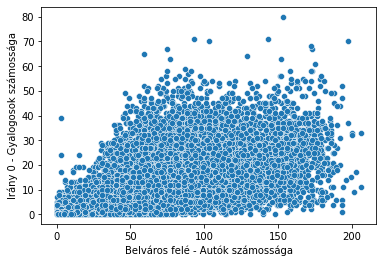

In [8]:
sns.scatterplot(x='Belváros felé - Autók számossága', y='Irány 0 - Gyalogosok számossága', data=df)

<AxesSubplot:xlabel='Hour', ylabel='Belváros felé - Autók számossága'>

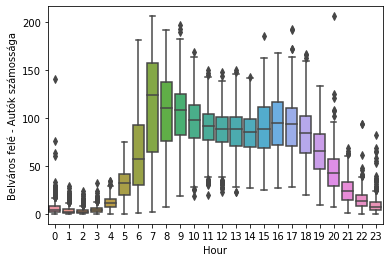

In [29]:
sns.boxplot(x='Hour', y='Belváros felé - Autók számossága', data=df)

<AxesSubplot:xlabel='Minute', ylabel='Belváros felé - Autók számossága'>

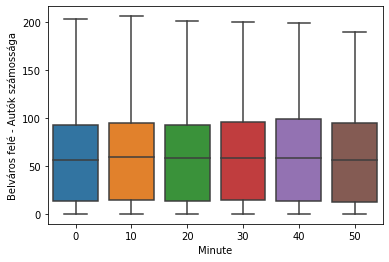

In [14]:
sns.boxplot(x='Minute', y='Belváros felé - Autók számossága', data=df)

In [15]:
X = df[['prev', 'atlaghom.', 'Hour', 'Minute', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values

y = df['Újszeged felé - Autók számossága'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
model = Sequential()

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [18]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=3000, callbacks=[early_stop])

Train on 19222 samples, validate on 8239 samples
Epoch 1/3000
19222/19222 [==============================] - 1s 52us/sample - loss: 1155.3890 - val_loss: 174.9808
Epoch 2/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 171.2748 - val_loss: 162.1298
Epoch 3/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 162.1522 - val_loss: 157.4068
Epoch 4/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 162.3614 - val_loss: 163.1458
Epoch 5/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 161.6544 - val_loss: 154.6198
Epoch 6/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 158.3212 - val_loss: 161.2219
Epoch 7/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 158.2002 - val_loss: 161.8311
Epoch 8/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 157.9741 - val_loss: 159.1416
Epoch 9/3000
19222/19222 [====================

19222/19222 [==============================] - 0s 26us/sample - loss: 120.3177 - val_loss: 119.3462
Epoch 73/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 119.4861 - val_loss: 120.0975
Epoch 74/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 118.8578 - val_loss: 117.3308
Epoch 75/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 120.1009 - val_loss: 114.5990
Epoch 76/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 119.1939 - val_loss: 123.1447
Epoch 77/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 119.8499 - val_loss: 116.0626
Epoch 78/3000
19222/19222 [==============================] - 1s 27us/sample - loss: 117.9599 - val_loss: 116.7352
Epoch 79/3000
19222/19222 [==============================] - 0s 26us/sample - loss: 119.0947 - val_loss: 114.5004
Epoch 80/3000
19222/19222 [==============================] - 1s 26us/sample - loss: 118.3543 - val_los

<AxesSubplot:>

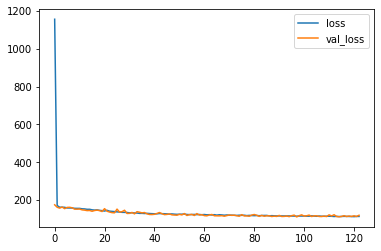

In [19]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [20]:
predictions = model.predict(X_test)

In [21]:
#sns.distplot((y_test-predictions),bins=50);

In [22]:
np.sqrt(mean_squared_error(y_test, predictions))

10.944310124379243

In [23]:
mean_absolute_error(y_test, predictions)

7.910913863218529

In [24]:
explained_variance_score(y_test, predictions)

0.9459434955073593

In [21]:
test_predictions = model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(8239,))
pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

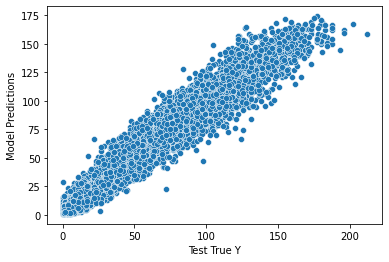

In [22]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [23]:
#X = df[['Hour', 'Minute', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values

new_data = [[20, 8, 0, 0, False,False,False,False,False,False,True,False,False,False,True,False]]
new_data = scaler.transform(new_data)
model.predict(new_data)

array([[18.73971]], dtype=float32)

In [24]:
df.describe()

,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,Hour,Minute,prev,DayOfWeek
count,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000,27461.000000
mean,58.874768,57.709333,8.763956,9.564218,10.014093,3.650049,3.394159,4.062598,1.074870,1.165107,11.618914,25.095590,57.708969,2.978952
std,45.504402,45.772268,7.964739,8.856689,10.115937,4.167789,3.970868,3.868860,1.347086,1.397211,6.908767,17.104786,45.772632,1.981192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,12.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,6.000000,10.000000,12.000000,1.000000
50%,57.000000,55.000000,7.000000,7.000000,7.000000,2.000000,2.000000,3.000000,1.000000,1.000000,12.000000,30.000000,55.000000,3.000000
75%,95.000000,94.000000,13.000000,15.000000,16.000000,5.000000,5.000000,6.000000,2.000000,2.000000,18.000000,40.000000,94.000000,5.000000
max,206.000000,228.000000,59.000000,57.000000,80.000000,50.000000,56.000000,47.000000,13.000000,15.000000,23.000000,50.000000,228.000000,6.000000


In [25]:
model.save('10min_prev_Újszeged_fele_autok.h5')
joblib.dump(scaler, '10min_prev_Újszeged_fele_autok.pkl') 

['10min_prev_Újszeged_fele_autok.pkl']

In [399]:

test = load_model('10min_Belvaros_fele_autok.h5')

In [84]:
test_data = [[10, 50, False,False,False,False,False,False,True,False,False,False,True,False]]

In [85]:
test_scaler = joblib.load('10min_Belvaros_fele_autok.pkl')

In [86]:
test_data = test_scaler.transform(test_data)

In [87]:
test.predict(test_data)

array([[78.78463]], dtype=float32)